In [ ]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set up directory paths to image files
train_path = "/content/drive/My Drive/C-NMC/training_data"
test_path = "/content/drive/My Drive/C-NMC/testing_data/C-NMC_test_final_phase_data"
val_path = "/content/drive/My Drive/C-NMC/validation_data/C-NMC_test_prelim_phase_data"

In [ ]:
# install tensorflow module
!pip install tensorflow

In [ ]:
# import relevant image, data analysis and deep learning libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers

%matplotlib inline

In [ ]:
# hyperparameters & setup
batch_size = 32 # number of samples per training batch
codings_size = 500 # dimensionality of noise vector
epochs = 200 # number of training epochs
critic_iterations = 5 # number of critic updates per generator update
lambda_gp = 10 # gradient penalty coefficient for regularization

In [ ]:
healthy_imgs = [] # initialize list to store healthy images
for file in os.listdir(train_path):
  for file2 in os.listdir(os.path.join(train_path, file, "hem")):
    img_path = os.path.join(train_path, file, "hem", file2) # build full image file path

    # load
    img = Image.open(img_path).convert("RGB") # open image and convert to rgb format
    img = img.resize((224, 224)) # resize to 224x224
    healthy_imgs.append(np.array(img, dtype=np.float32)) # convert image to numpy array and append to list

# normalize
healthy_imgs = (np.array(healthy_imgs) / 127.5) - 1.0 # scale pixel values to range [-1.0, 1.0]

In [ ]:
# length of total images with shape
healthy_imgs.shape

(3389, 224, 224, 3)

In [ ]:
# define function to create generator model
def make_generator():
  model = tf.keras.Sequential(name="generator") # initialize sequential model with name

  # dense & reshape: from codings_size to a 7x7x128 feature map
  model.add(layers.Dense(7 * 7 * 128, use_bias=False, input_shape=(codings_size,))) # dense layer without bias
  model.add(layers.BatchNormalization()) # normalize activations
  model.add(layers.LeakyReLU()) # use leaky relu activation
  model.add(layers.Reshape((7, 7, 128))) # reshape output to 7x7x128

  ### upsampling layers to reach 224x224

  # 7x7 -> 14x14
  model.add(layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 14x14 -> 28x28
  model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 28x28 -> 56x56
  model.add(layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 56x56 -> 112x112
  model.add(layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", use_bias=False))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # 112x112 -> 224x224
  model.add(layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", use_bias=False)) # fifth upsampling
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # output layer: 224x224x1 image with values in [-1, 1]
  model.add(layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding="same", activation="tanh")) # final transposed conv to rgb output

  return model # return constructed generator model

In [ ]:
generator = make_generator() # create generator model
generator.summary() # print summary of generator architecture

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 6272)           │     3,136,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 128)    │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 56, 56, 64)     │       102,400 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 112, 112, 32)   │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 224, 224, 32)   │        25,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,958,371 (15.10 MB)

 Trainable params: 3,945,187 (15.05 MB)

 Non-trainable params: 13,184 (51.50 KB)

In [ ]:
# define function to create critic model (wgan discriminator)
def make_critic():
  model = tf.keras.Sequential(name="critic") # initialize sequential model with name

  model.add(layers.Conv2D(64, kernel_size=5, strides=2, padding="same", input_shape=[224, 224, 3])) # conv layer to reduce spatial dimensions
  model.add(layers.LeakyReLU(alpha=0.3)) # apply leaky relu activation
  model.add(layers.Dropout(0.3)) # apply dropout for regularization

  model.add(layers.Conv2D(128, kernel_size=5, strides=2, padding="same"))
  model.add(layers.LeakyReLU(alpha=0.3))
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten()) # flatten feature maps into vector

  # no activation here: critic outputs a real-valued score
  model.add(layers.Dense(1)) # dense layer to output a single score (WGAN critic)

  return model # return constructed critic model

In [ ]:
critic = make_critic() # create critic model
critic.summary() # print summary of critic architecture

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 112, 112, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │       401,409 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 611,201 (2.33 MB)

 Trainable params: 611,201 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5) # optimizer for generator with tuned learning rate
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5) # optimizer for critic using same hyperparameters for balance

In [ ]:
# gradient penalty function - calculates gradient penalty for batch of real and fake images
def gradient_penalty(critic, real, fake, batch_size):
  alpha = tf.random.uniform([batch_size, 1, 1, 1], 0., 1.) # sample random coefficients for interpolation
  interpolated = alpha * real + (1 - alpha) * fake # interpolate between real and fake samples

  # set up gradient tape to compute gradients
  with tf.GradientTape() as tape:
      tape.watch(interpolated) # explicitly watch interpolated samples
      critic_interpolated = critic(interpolated, training=True) # pass interpolated samples through critic

  grads = tape.gradient(critic_interpolated, [interpolated])[0] # compute gradients of critic output w.r.t. interpolated input
  grads = tf.reshape(grads, [batch_size, -1]) # flatten gradients to [batch_size, num_features]
  grad_norm = tf.norm(grads, axis=1) # compute L2 norm of gradients for each sample
  gp = tf.reduce_mean((grad_norm - 1.)**2) # calculate gradient penalty
  return gp # return gradient penalty scalar

In [ ]:
# compute total loss for the critic in wgan-gp
def critic_loss(critic_real, critic_fake, gp, lambda_gp):
  # critic aims to maximize difference between scores on real and fake
  return tf.reduce_mean(critic_fake) - tf.reduce_mean(critic_real) + lambda_gp * gp # wasserstein loss plus gradient penalty

# compute generator loss based on critic's output on fake samples
def generator_loss(critic_fake):
  # generator tries to minimize critic's score on fake images
  return -tf.reduce_mean(critic_fake) # negative mean critic score encourages more realistic generations

In [ ]:
# training step function
@tf.function
def train_step(real_images): # single training step for wgan-gp
  batch_size = tf.shape(real_images)[0] # dynamically get batch size

  # train critic for several iterations
  for _ in range(critic_iterations):
      noise = tf.random.normal([batch_size, codings_size]) # generate noise for fake images
      with tf.GradientTape() as critic_tape: # record operations for critic gradient
          fake_images = generator(noise, training=True) # generate fake images
          critic_real = critic(real_images, training=True) # critic output for real images
          critic_fake = critic(fake_images, training=True) # critic output for fake images
          gp = gradient_penalty(critic, real_images, fake_images, batch_size) # compute gradient penalty
          c_loss = critic_loss(critic_real, critic_fake, gp, lambda_gp) # total critic loss
      critic_gradients = critic_tape.gradient(c_loss, critic.trainable_variables) # compute gradients
      critic_optimizer.apply_gradients(zip(critic_gradients, critic.trainable_variables)) # update critic weights

  # train generator
  noise = tf.random.normal([batch_size, codings_size]) # generate new noise vector
  with tf.GradientTape() as gen_tape: # record operations for generator gradient
      fake_images = generator(noise, training=True) # generate fake images
      critic_fake = critic(fake_images, training=True) # critic evaluates fake images
      g_loss = generator_loss(critic_fake) # compute generator loss
  generator_gradients = gen_tape.gradient(g_loss, generator.trainable_variables) # compute gradients
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables)) # update generator weights

  return c_loss, g_loss # return current losses for tracking

In [ ]:
# create shuffled and batched dataset from healthy images
dataset = tf.data.Dataset.from_tensor_slices(healthy_imgs).shuffle(buffer_size=1000).batch(batch_size)

Epoch 1/200
Epoch 1, Critic Loss: -198.9949, Generator Loss: -744.7570
Epoch 1, Critic Loss: -198.9949, Generator Loss: -744.7570


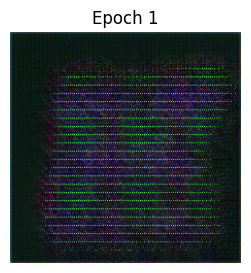

Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 11, Critic Loss: -14.2697, Generator Loss: -217.0969
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 21, Critic Loss: -9.3645, Generator Loss: -187.7926
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 26, Critic Loss: -11.3266, Generator Loss: -102.5960


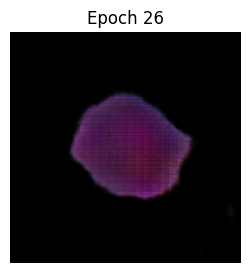

Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 31, Critic Loss: -20.1448, Generator Loss: -39.1664
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 41, Critic Loss: -8.9720, Generator Loss: -71.0391
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 51, Critic Loss: -5.0615, Generator Loss: -63.4072
Epoch 51, Critic Loss: -5.0615, Generator Loss: -63.4072


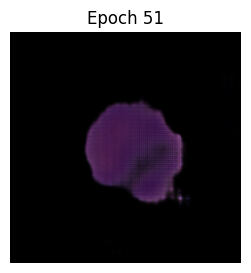

Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 61, Critic Loss: -6.5302, Generator Loss: -67.7186
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/200
Epoch 71/200
Epoch 71, Critic Loss: -5.4254, Generator Loss: -68.7645
Epoch 72/200
Epoch 73/200
Epoch 74/200
Epoch 75/200
Epoch 76/200
Epoch 76, Critic Loss: -5.0672, Generator Loss: -63.9131


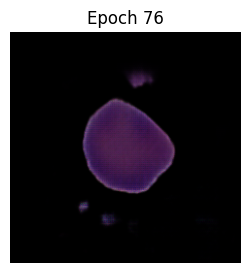

Epoch 77/200
Epoch 78/200
Epoch 79/200
Epoch 80/200
Epoch 81/200
Epoch 81, Critic Loss: -8.4806, Generator Loss: -111.4937
Epoch 82/200
Epoch 83/200
Epoch 84/200
Epoch 85/200
Epoch 86/200
Epoch 87/200
Epoch 88/200
Epoch 89/200
Epoch 90/200
Epoch 91/200
Epoch 91, Critic Loss: -9.0141, Generator Loss: -124.6710
Epoch 92/200
Epoch 93/200
Epoch 94/200
Epoch 95/200
Epoch 96/200
Epoch 97/200
Epoch 98/200
Epoch 99/200
Epoch 100/200
Epoch 101/200
Epoch 101, Critic Loss: -5.2271, Generator Loss: -51.1055
Epoch 101, Critic Loss: -5.2271, Generator Loss: -51.1055


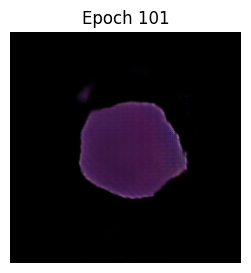

Epoch 102/200
Epoch 103/200
Epoch 104/200
Epoch 105/200
Epoch 106/200
Epoch 107/200
Epoch 108/200
Epoch 109/200
Epoch 110/200
Epoch 111/200
Epoch 111, Critic Loss: -9.1893, Generator Loss: -120.1194
Epoch 112/200
Epoch 113/200
Epoch 114/200
Epoch 115/200
Epoch 116/200
Epoch 117/200
Epoch 118/200
Epoch 119/200
Epoch 120/200
Epoch 121/200
Epoch 121, Critic Loss: -6.6509, Generator Loss: -16.4791
Epoch 122/200
Epoch 123/200
Epoch 124/200
Epoch 125/200
Epoch 126/200
Epoch 126, Critic Loss: -6.7493, Generator Loss: -104.7464


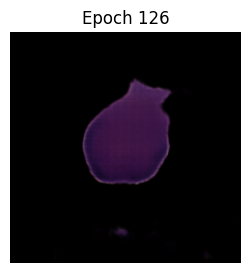

Epoch 127/200
Epoch 128/200
Epoch 129/200
Epoch 130/200
Epoch 131/200
Epoch 131, Critic Loss: -3.5604, Generator Loss: -80.0749
Epoch 132/200
Epoch 133/200
Epoch 134/200
Epoch 135/200
Epoch 136/200
Epoch 137/200
Epoch 138/200
Epoch 139/200
Epoch 140/200
Epoch 141/200
Epoch 141, Critic Loss: 2.0303, Generator Loss: -78.0835
Epoch 142/200
Epoch 143/200
Epoch 144/200
Epoch 145/200
Epoch 146/200
Epoch 147/200
Epoch 148/200
Epoch 149/200
Epoch 150/200
Epoch 151/200
Epoch 151, Critic Loss: -0.4612, Generator Loss: -51.9790
Epoch 151, Critic Loss: -0.4612, Generator Loss: -51.9790


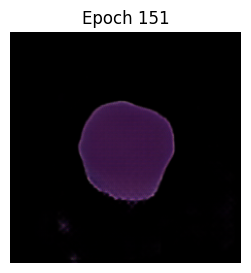

Epoch 152/200
Epoch 153/200
Epoch 154/200
Epoch 155/200
Epoch 156/200
Epoch 157/200
Epoch 158/200
Epoch 159/200
Epoch 160/200
Epoch 161/200
Epoch 161, Critic Loss: -4.6222, Generator Loss: -109.9127
Epoch 162/200
Epoch 163/200
Epoch 164/200
Epoch 165/200
Epoch 166/200
Epoch 167/200
Epoch 168/200
Epoch 169/200
Epoch 170/200
Epoch 171/200
Epoch 171, Critic Loss: -8.6780, Generator Loss: -96.2559
Epoch 172/200
Epoch 173/200
Epoch 174/200
Epoch 175/200
Epoch 176/200
Epoch 176, Critic Loss: -1.7135, Generator Loss: 2.9314


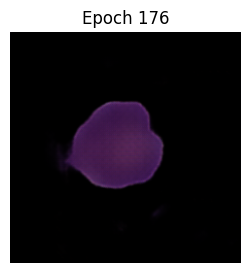

Epoch 177/200
Epoch 178/200
Epoch 179/200
Epoch 180/200
Epoch 181/200
Epoch 181, Critic Loss: -5.9997, Generator Loss: -17.2349
Epoch 182/200
Epoch 183/200
Epoch 184/200
Epoch 185/200
Epoch 186/200
Epoch 187/200
Epoch 188/200
Epoch 189/200
Epoch 190/200
Epoch 191/200
Epoch 191, Critic Loss: -10.3616, Generator Loss: -242.9302
Epoch 192/200
Epoch 193/200
Epoch 194/200
Epoch 195/200
Epoch 196/200
Epoch 197/200
Epoch 198/200
Epoch 199/200
Epoch 200/200
Training finished!
Total time: 36035.48 seconds


In [ ]:
# training loop
c_losses = [] # store critic losses
g_losses = [] # store generator losses
start_time = time.time() # record start time

for epoch in range(epochs): # loop through all epochs
  print(f"Epoch {epoch+1}/{epochs}") # show progress
  for image_batch in dataset: # iterate through dataset
      c_loss, g_loss = train_step(image_batch) # perform one training step

  c_losses.append(c_loss) # save critic loss
  g_losses.append(g_loss) # save generator loss

  # display progress every 10 and 25 epochs
  if (epoch) % 10 == 0:
    print(f"Epoch {epoch+1}, Critic Loss: {c_loss.numpy():.4f}, Generator Loss: {g_loss.numpy():.4f}")
  if (epoch) % 25 == 0:
    print(f"Epoch {epoch+1}, Critic Loss: {c_loss.numpy():.4f}, Generator Loss: {g_loss.numpy():.4f}")

    noise = tf.random.normal([1, codings_size]) # generate sample noise
    generated_image = generator(noise, training=False) # generate image

    plt.figure(figsize=(4,3))
    plt.imshow(generated_image[0, :, :, :] * 0.5 + 0.5) # rescale image from [-1,1] to [0,1]
    plt.title(f"Epoch {epoch+1}")
    plt.axis("off")
    plt.show()

    # save generator and critic models + weights
    generator.save(f'/content/drive/MyDrive/wgan_generator_epoch-{epoch}.keras')
    critic.save(f'/content/drive/MyDrive/wgan_discriminator_epoch-{epoch}.keras')
    generator.save_weights(f'/content/drive/MyDrive/wgan_generator_weights_epoch-{epoch}.weights.h5')
    critic.save_weights(f'/content/drive/MyDrive/wgan_critic_weights_epoch-{epoch}.weights.h5')

print("Training finished!")
print("Total time: {:.2f} seconds".format(time.time() - start_time)) # show total training time

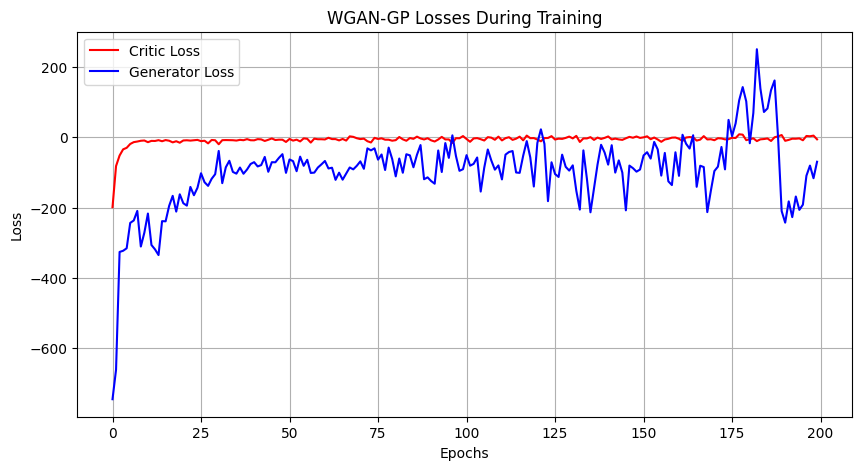

In [ ]:
# plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(c_losses, label="Critic Loss", color='red') # plot critic loss in red
plt.plot(g_losses, label="Generator Loss", color='blue') # plot generator loss in blue
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("WGAN-GP Losses During Training")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
generator.save("wgan_generator.keras") # save full generator model
critic.save("wgan_critic.keras") # save full critic model

In [ ]:
generator.save_weights("wgan_generator_weights.weights.h5") # save only generator weights
critic.save_weights("wgan_critic_weights.weights.h5") # save only critic weights